# Import Libraries and Load Data

In [59]:
# pip install medmnist

In [71]:
import medmnist
from medmnist import INFO, BloodMNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [72]:
# Load the BloodMNIST dataset with high resolution for all splits
train_data = BloodMNIST(split='train', download=True, as_rgb=True, size=224)
val_data = BloodMNIST(split='val', download=True, as_rgb=True, size=224)
test_data = BloodMNIST(split='test', download=True, as_rgb=True, size=224)

Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz


# See Class Distribution

In [78]:
train_data

Dataset BloodMNIST of size 224 (bloodmnist_224)
    Number of datapoints: 11959
    Root location: /Users/lowi33/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'Immature Granulocytes', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0

In [73]:
# Get dataset information
blood_info = INFO['bloodmnist']
n_classes_blood = len(blood_info['label'])

# Get the class labels
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'

# Count the number of instances for each class in BloodMNIST
label_counts_blood = Counter([int(label) for _, label in blood_dataset])

In [74]:
# Print the distribution of class labels for BloodMNIST
print("\nClass Label Distribution in BloodMNIST:")
for key, count in label_counts_blood.items():
    print(f"Class {key}: {count} instances")


Class Label Distribution in BloodMNIST:
Class 7: 1643 instances
Class 3: 2026 instances
Class 6: 2330 instances
Class 2: 1085 instances
Class 1: 2181 instances
Class 5: 993 instances
Class 0: 852 instances
Class 4: 849 instances


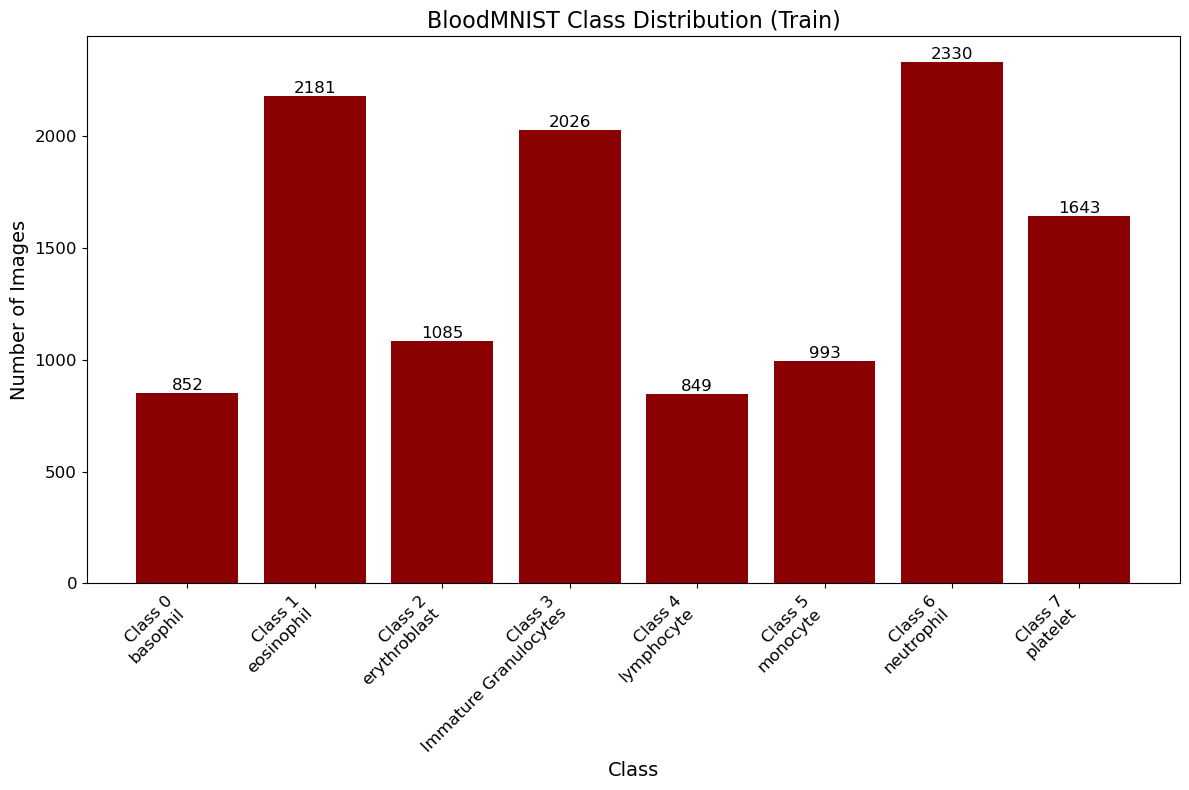

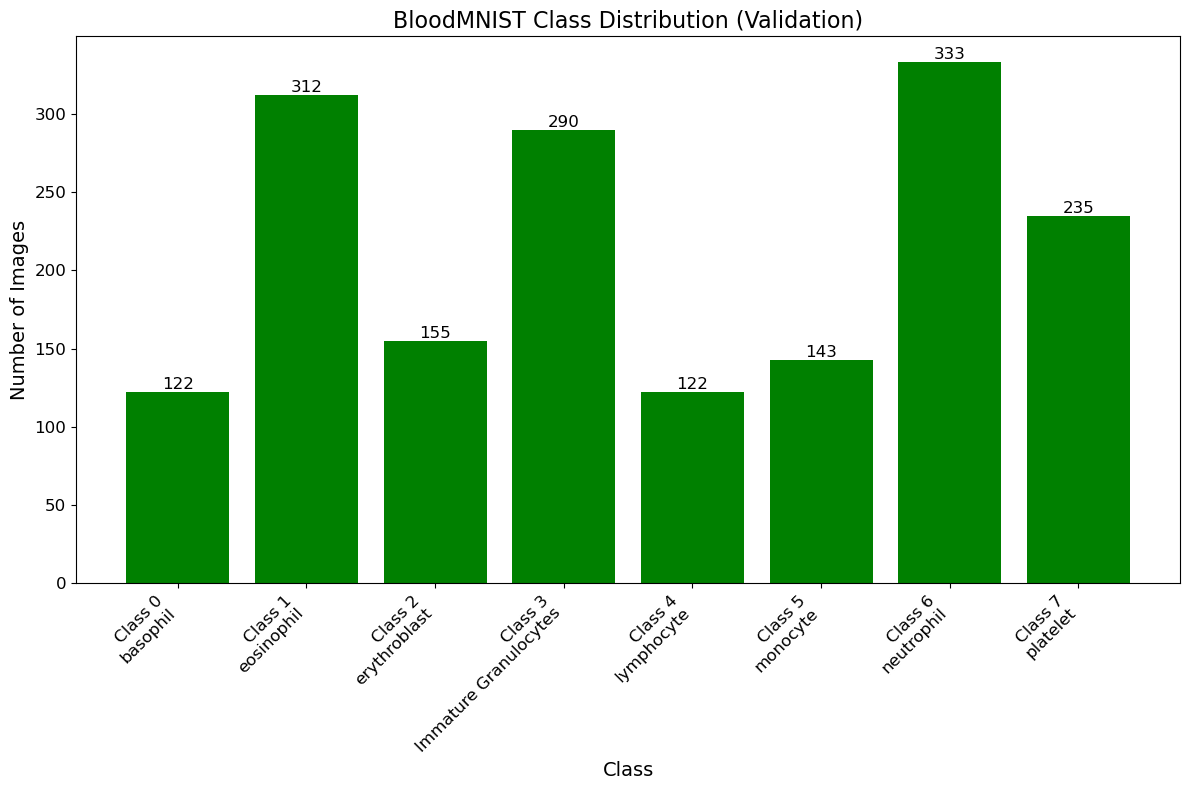

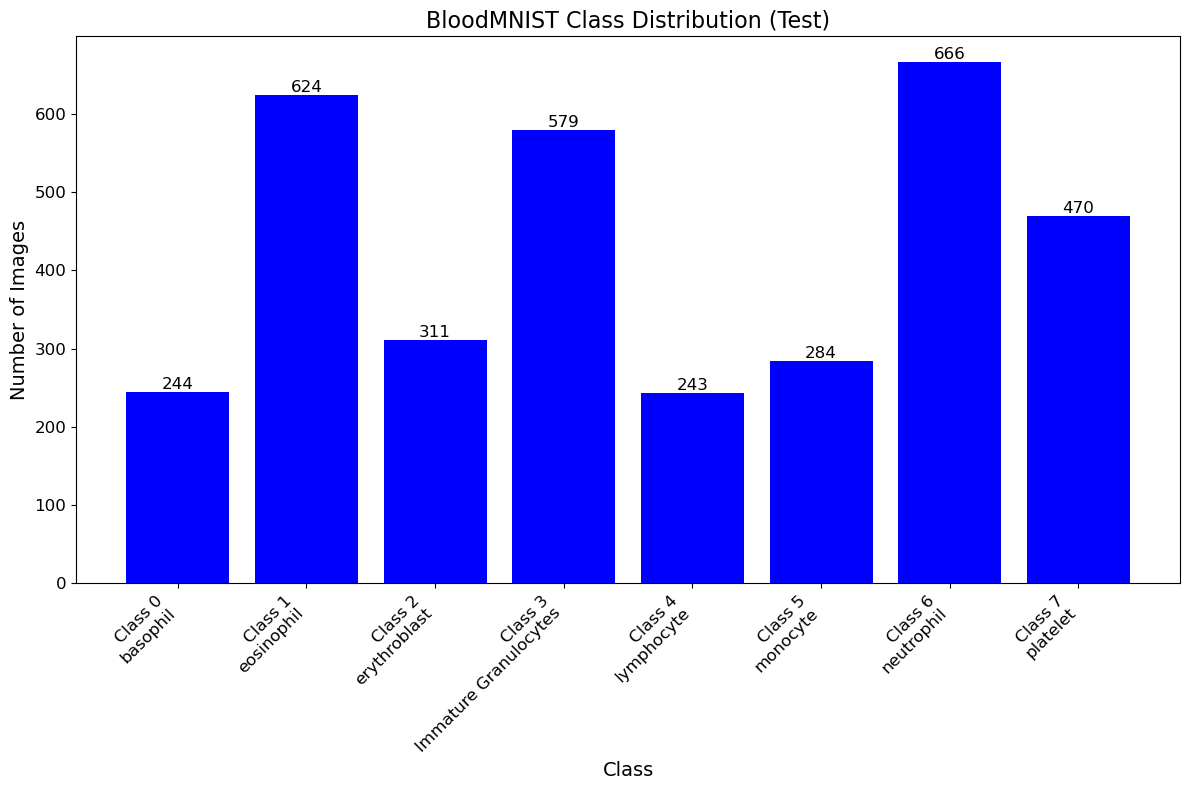

In [75]:
# Count the number of instances for each class in each split
label_counts_train = Counter([int(label) for _, label in train_data])
label_counts_val = Counter([int(label) for _, label in val_data])
label_counts_test = Counter([int(label) for _, label in test_data])

def plot_class_distribution(label_counts, class_labels, title, color):
    classes = list(range(len(class_labels)))  # Ensure all classes are shown
    counts = [label_counts.get(i, 0) for i in classes]
    labels = [f"Class {i}\n{class_labels[str(i)]}" for i in classes]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(classes, counts, tick_label=labels, color=color)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on top of each column
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot BloodMNIST class distribution
plot_class_distribution(label_counts_train, class_labels_blood, 'BloodMNIST Class Distribution (Train)', 'darkred')
plot_class_distribution(label_counts_val, class_labels_blood, 'BloodMNIST Class Distribution (Validation)', 'green')
plot_class_distribution(label_counts_test, class_labels_blood, 'BloodMNIST Class Distribution (Test)', 'blue')


# Get Example Images

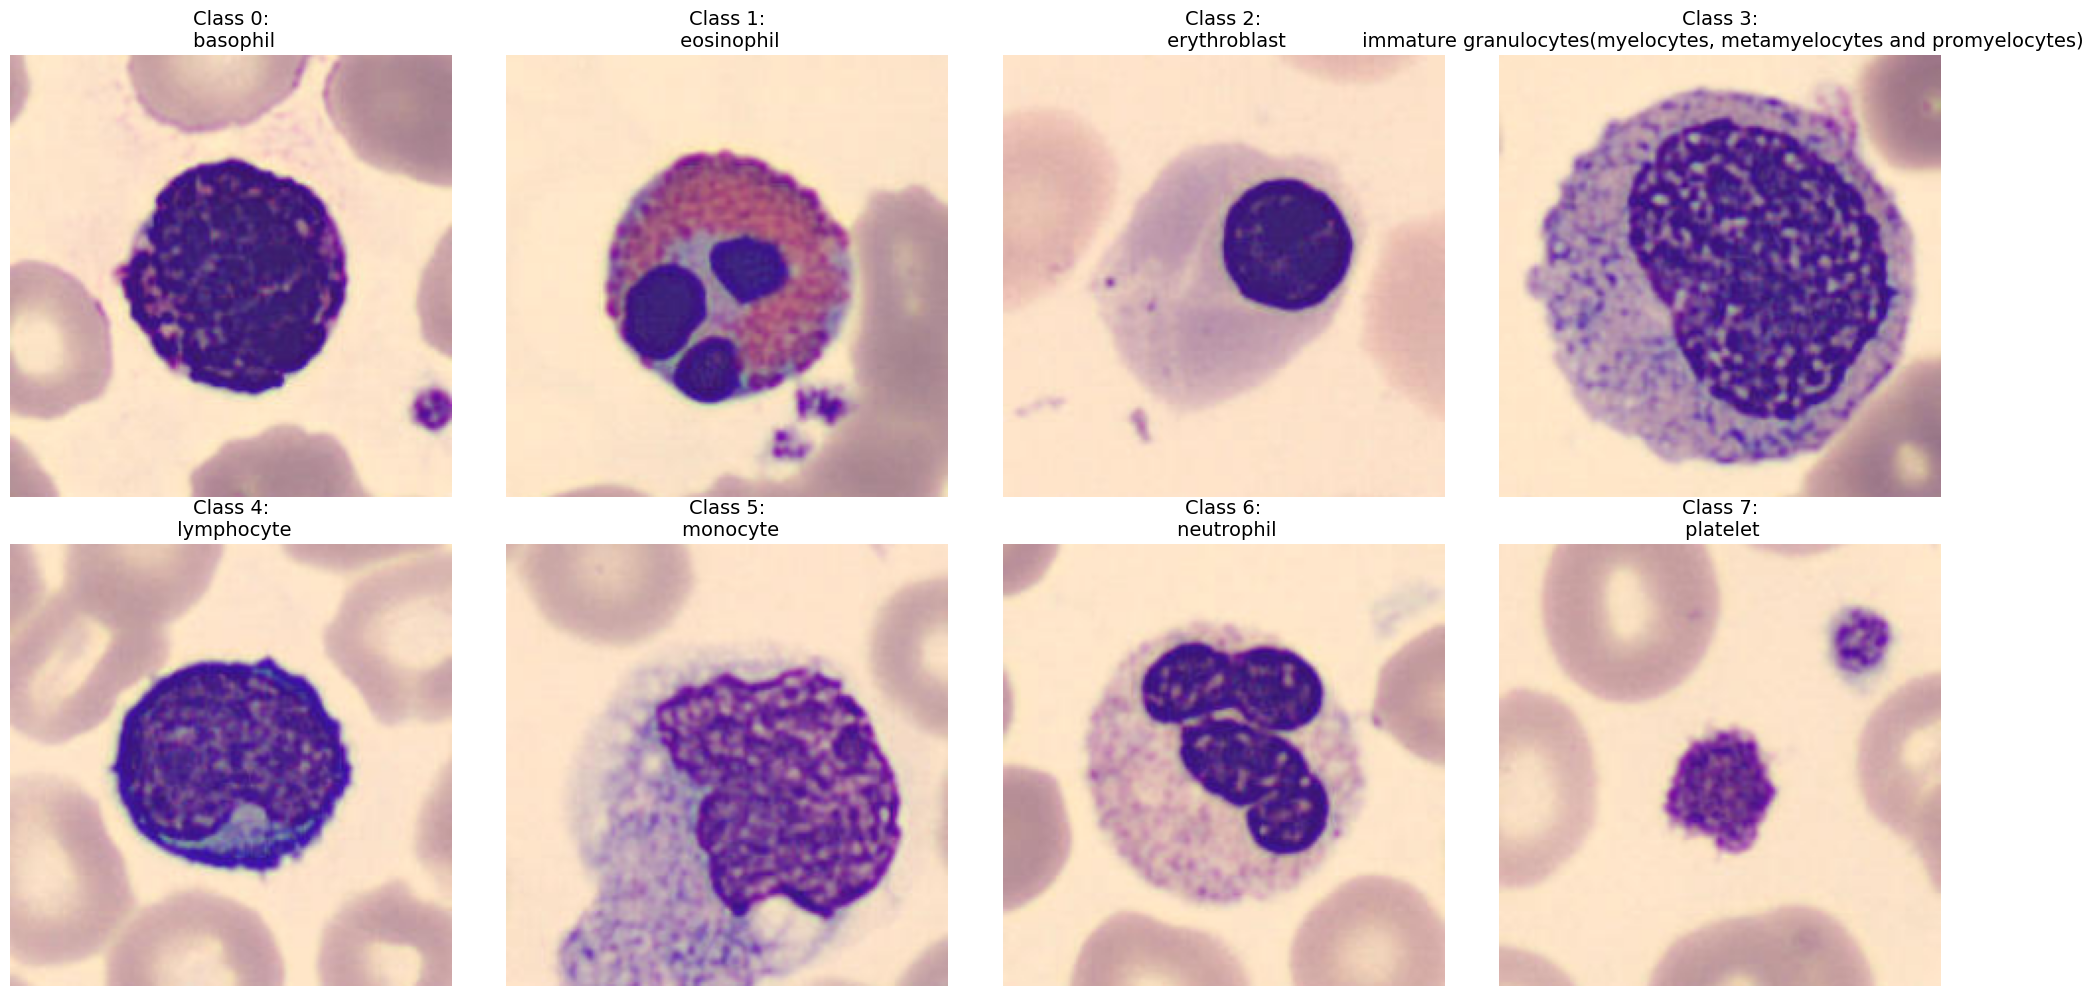

In [65]:
def show_one_image_per_class(dataset, n_classes, class_labels):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes
    class_count = 0

    # Sort images by label
    sorted_dataset = sorted(dataset, key=lambda x: int(x[1]))

    for img, label in sorted_dataset:
        label = int(label)
        if not class_found[label]:
            img = np.array(img)
            axes[class_count].imshow(img)
            axes[class_count].set_title(f"Class {label}:\n {class_labels[str(label)]}", fontsize=14)
            axes[class_count].axis('off')
            class_found[label] = True
            class_count += 1
        if class_count == n_classes:
            break

    # Remove any empty subplots
    for i in range(class_count, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Show one example image from the training dataset for each class
show_one_image_per_class(train_data, n_classes_blood, class_labels_blood)